# Electrochemical CO sensor data preprocessing

- Pollutant: Carbon Monoxide
- Sensor: Alphasense CO-B4

## Constants

### Sensors IDs

### API Constants

In [91]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
RAW_DATA_DIR = "data/raw-data-monit-fix-2022-2023-Diamante/"
RAW_FILE_NAME = "ISB_CO.CSV"

SENSOR_FILE_DIR = 'data/input/'
SENSOR_NAME = 'alpha_co_conc'
SENSOR_FILE_NAME = SENSOR_NAME + 'web_dataframe.csv'

### Sensor Constants

In [92]:
M = 28.01
lower_limit = 4.0
upper_limit = 1e6
t_90 = 30     # sensor takes 30 seconds to reach a value of 10e3
t_90_value = 10e3
sampling_period = 15 * 60

# Alphasense CO Sensor Data

In [93]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_BR')

'pt_BR'

In [94]:
from GetSensorDataService import GetSensorDataService

get_sensor_data_service = GetSensorDataService(HOST, PORT)
sensor_data = get_sensor_data_service.get_data_from_file(RAW_DATA_DIR+RAW_FILE_NAME, sensor_name=SENSOR_NAME)
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/GetSensorDataService.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


## Upload Data from File

In [95]:
import pandas as pd

df = pd.read_csv(SENSOR_FILE_DIR + SENSOR_FILE_NAME)
df.head()

,Unnamed: 0,latitude,longitude,measuring,DateTime
0,0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [96]:
# Remove the first column with the indexes and save data into web dataframe
web_dataframe = df.drop(df.columns[0], axis='columns')
web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = web_dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_26641/166902210.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring
DateTime,,,
2022-11-20 13:45:00,-28.456899,-48.972999,125.92
2022-11-20 14:00:00,NaN,NaN,NaN
2022-11-20 14:15:00,NaN,NaN,NaN
2022-11-20 14:30:00,NaN,NaN,NaN
2022-11-20 14:45:00,NaN,NaN,NaN
...,...,...,...
2023-05-23 08:15:00,NaN,NaN,NaN
2023-05-23 08:30:00,NaN,NaN,NaN
2023-05-23 08:45:00,NaN,NaN,NaN


### Plot raw data

<Axes: xlabel='DateTime'>

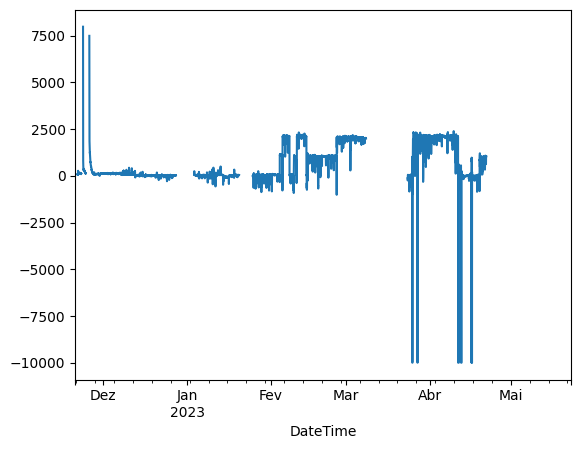

In [97]:
sensor_dataframe['measuring'].plot()

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

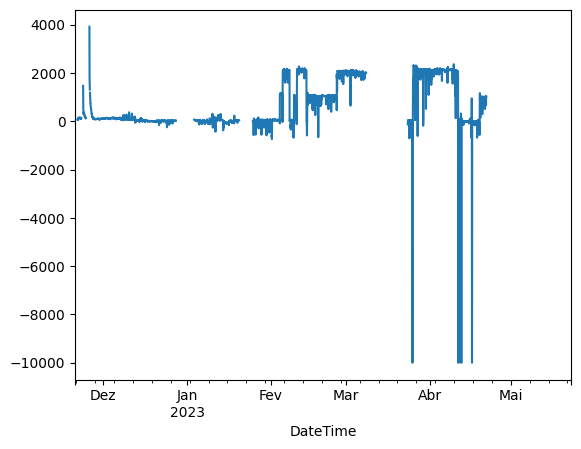

In [98]:
sensor_dataframe['raw measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['measuring'].rolling(window=4).median()
sensor_dataframe['Hour'] = sensor_dataframe.index.hour
sensor_dataframe['measuring'].plot()

### Convert to ppm

In [99]:
sensor_dataframe['value'] = sensor_dataframe['measuring'].map(lambda v: v/1e3)

## Tag data
Apply tags to the data according to the quality control processes described above

In [100]:
sensor_dataframe['Tag'] = 'VALID'

#### Tag data during stabilizing period
AQMesh recomends to considering the first two days after installation as a period for stabilization. In our case, a period of seven days was selected in order to remove outliers candidates detected during that period. For that purpose we detect the first 7 days of uninterrupted measurements

,latitude,longitude,measuring,raw measuring,Hour,value,Tag
DateTime,,,,,,,
2022-11-20 13:45:00,-28.456899,-48.972999,NaN,125.92,13,NaN,STABILIZING
2022-11-20 14:00:00,NaN,NaN,NaN,NaN,14,NaN,STABILIZING
2022-11-20 14:15:00,NaN,NaN,NaN,NaN,14,NaN,STABILIZING
2022-11-20 14:30:00,NaN,NaN,NaN,NaN,14,NaN,STABILIZING
2022-11-20 14:45:00,NaN,NaN,NaN,NaN,14,NaN,STABILIZING


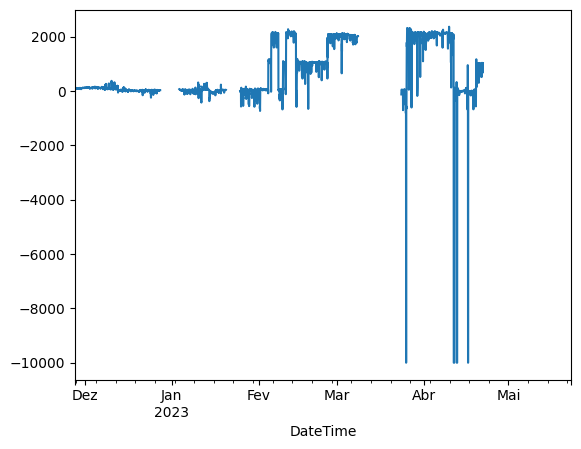

In [101]:
# Identify consecutive measurements (15 mins between each)
consecutive_periods = sensor_dataframe.index.to_series().diff().dt.seconds == 900

# Select the first seven days of consecutive measurements (96 = 24 * 60 mins / 15 mins, amount of 15 mins periods in a day)
last_stabilizing_index = sensor_dataframe[consecutive_periods].head(96 * 7).index[-1] # 7 days
sensor_dataframe.loc[sensor_dataframe.index[0]:last_stabilizing_index,'Tag'] = 'STABILIZING'
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()
sensor_dataframe.head()

#### Tag values that are missing, are greater than sensor span or are lower than sensor resolution

The upper limit was too high that affected the graph resolution, therefore it is not plotted

<Axes: xlabel='DateTime'>

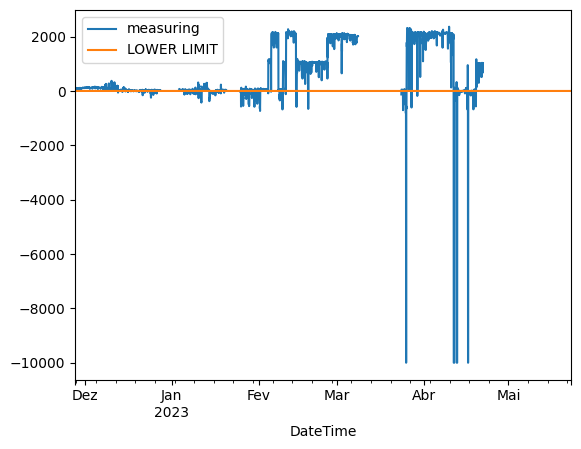

In [102]:
sensor_dataframe['UPPER LIMIT'] = upper_limit
sensor_dataframe['LOWER LIMIT'] = lower_limit
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'LOWER LIMIT']].resample('15T').mean().plot()

In [103]:
import numpy as np
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_sensor_limits(value, tag, lower_limit, upper_limit):
 if (tag != 'VALID'): return tag
 return sensor_analysis.get_tags_from_series(value=value,
                                             lower_limit=lower_limit,
                                             upper_limit=upper_limit)

sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Tag']]
                                        .apply(lambda df: tag_by_sensor_limits(value=df[0], tag=df[1],
                                                                              lower_limit=lower_limit,
                                                                              upper_limit=upper_limit),
                                                axis=1))

#### Plot valid data after removing samples bellow lower limit

Text(0, 0.5, 'Concentração (ppb)')

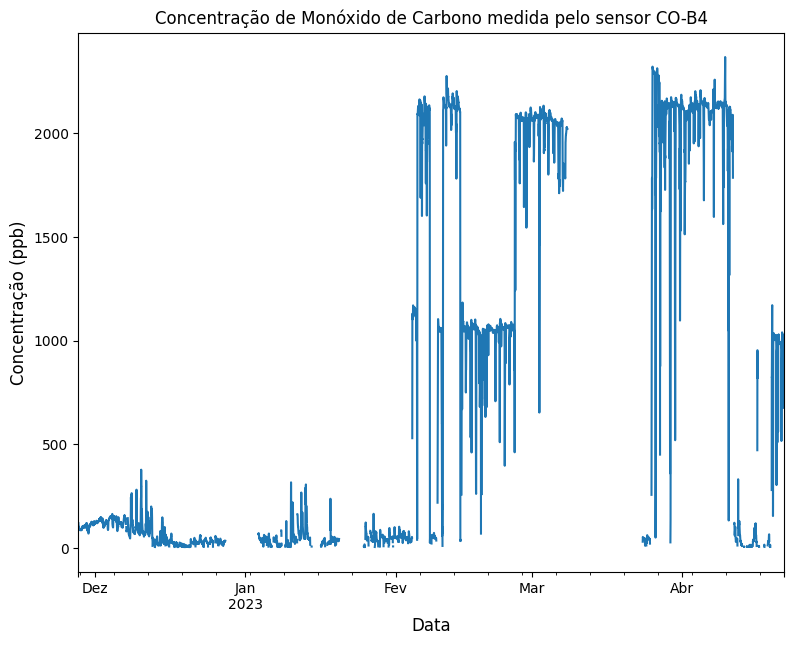

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Monóxido de Carbono').resample('15T').mean().plot()
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

### Data Tag contabilization

In [105]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
STABILIZING,673,3.813679
BADSPIKE,0,0.0
VALID,9658,54.728849
TOTAL,17647,100.0


## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

In [106]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag'])

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

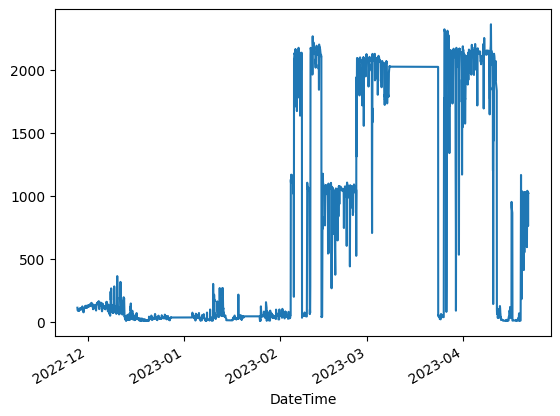

In [107]:
valid_dataframe['raw measuring'] = valid_dataframe['measuring']
valid_dataframe['measuring'] = valid_dataframe['measuring'].rolling(window=4).median()
valid_dataframe['measuring'].plot()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


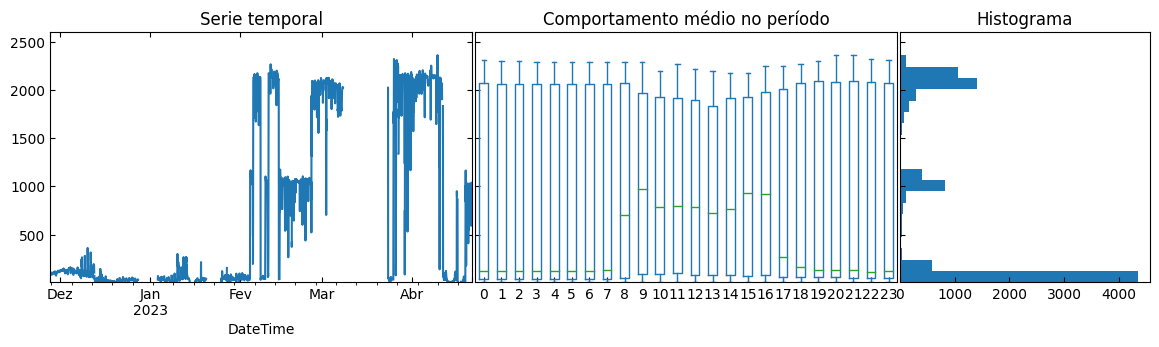

In [108]:
valid_dataframe = valid_dataframe.resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

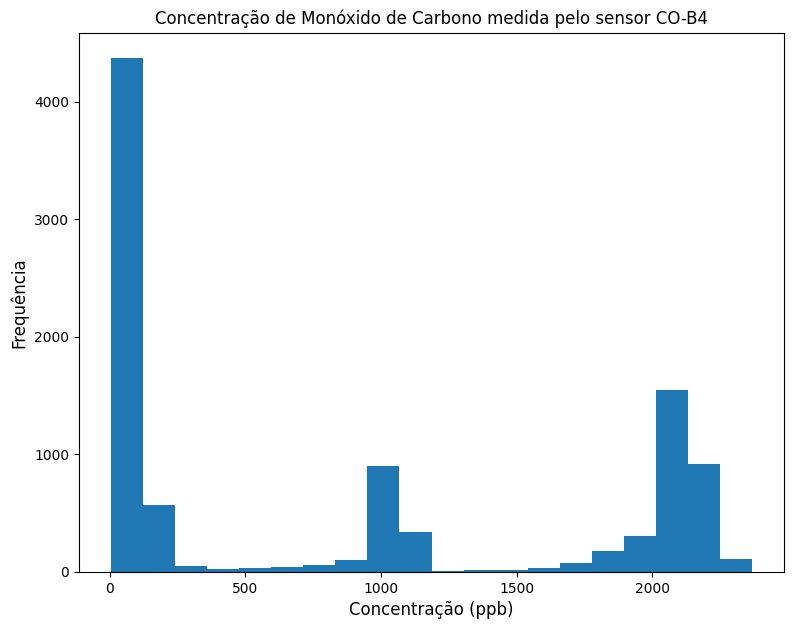

In [109]:
fig, ax = plt.subplots(figsize=(1.3*7,7))
(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Monóxido de Carbono')
 .resample('15T').mean().hist(bins=20))
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4')
ax.set_xlabel('Concentração (ppb)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(False)

## Change point Analysis

### Change point analysis of 15 mins data

In [110]:
import ruptures as rpt

series = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring']
signal = np.array(series).reshape(-1, 1)
algo = rpt.Pelt(model="rbf", jump=50, min_size=100).fit(signal=signal)
result = algo.predict(pen=10)
result

[4400, 4500, 4750, 4850, 4950, 5300, 6350, 7350, 7500, 9100, 9400, 9658]

In [111]:
change_point_index = series[[x - 1 for x in result]].index
sensor_dataframe['CHANGE POINT'] = False
sensor_dataframe['CHANGE POINT'].loc[change_point_index] = True

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_26641/717246363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_dataframe['CHANGE POINT'].loc[change_point_index] = True


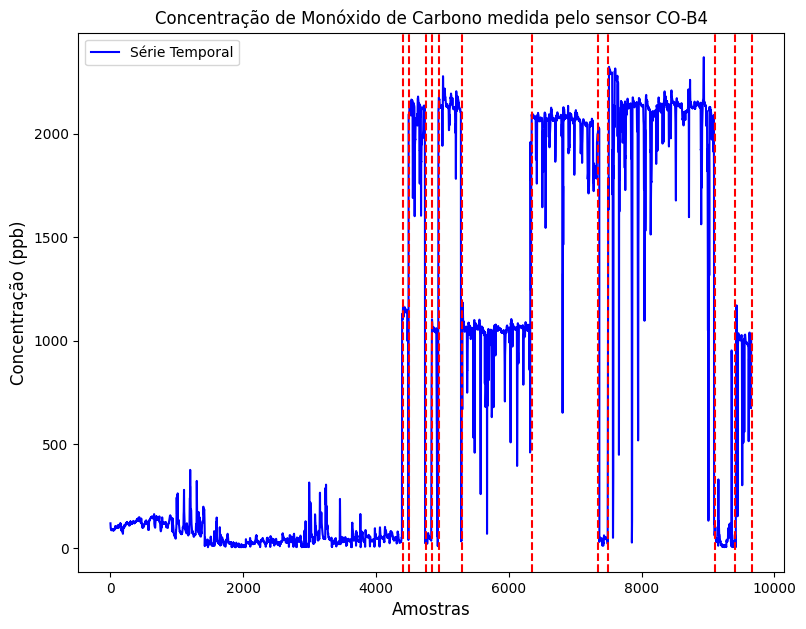

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.plot(signal, label='Série Temporal', color='blue')
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4')
ax.set_xlabel('Amostras', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

# Plot change points
for point in result:
    plt.axvline(x=point, color='red', linestyle='--')

# Show the plot
plt.legend()
plt.show()

#### Tag dataframe with changepoints

In [113]:
sensor_dataframe.loc[change_point_index[0]:, 'Tag'] = (sensor_dataframe.loc[change_point_index[0]:, 'Tag']
                                                       .apply(lambda t: 'REBASE' if t == 'VALID' else t))
sensor_dataframe[sensor_dataframe['Tag'] == 'REBASE'].head()

,latitude,longitude,measuring,raw measuring,Hour,value,Tag,UPPER LIMIT,LOWER LIMIT,CHANGE POINT
DateTime,,,,,,,,,,
2023-02-04 11:15:00,-28.456899,-48.972999,1108.640,1109.40,11,1.108640,REBASE,1000000.0,4.0,True
2023-02-04 11:30:00,-28.456899,-48.972999,1110.445,1112.44,11,1.110445,REBASE,1000000.0,4.0,False
2023-02-04 11:45:00,-28.456899,-48.972999,1110.445,1104.39,11,1.110445,REBASE,1000000.0,4.0,False
2023-02-04 12:00:00,-28.456899,-48.972999,1110.920,1113.96,12,1.110920,REBASE,1000000.0,4.0,False
2023-02-04 12:15:00,-28.456899,-48.972999,1113.200,1121.73,12,1.113200,REBASE,1000000.0,4.0,False


#### Data Tag contabilization

In [114]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
STABILIZING,673,3.813679
BADSPIKE,0,0.0
VALID,4399,24.92775
REBASE,5259,29.801099
TOTAL,17647,100.0


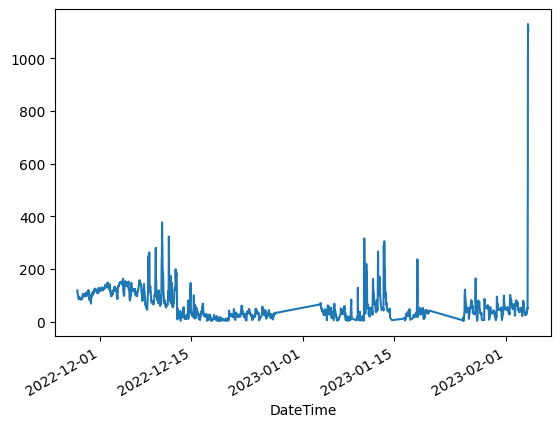

In [115]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].plot()
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

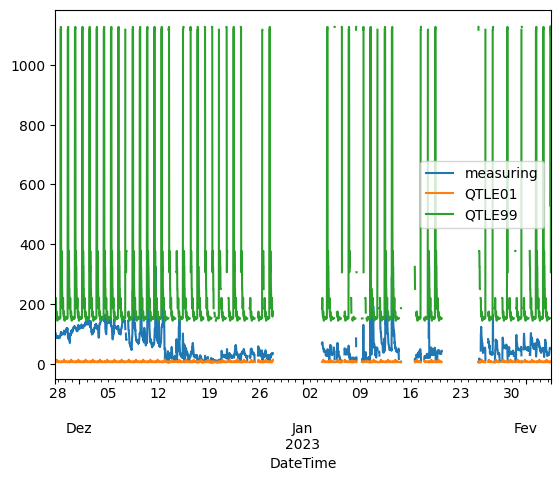

In [116]:
import numpy as np

global_qtle_01 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

### Tag data according to quantiles

In [117]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
BADSPIKE,0,0.0
VALID,4273,24.213747
LTQTLE01,63,0.357001
GTQTLE99,63,0.357001
REBASE,5259,29.801099
TOTAL,17647,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

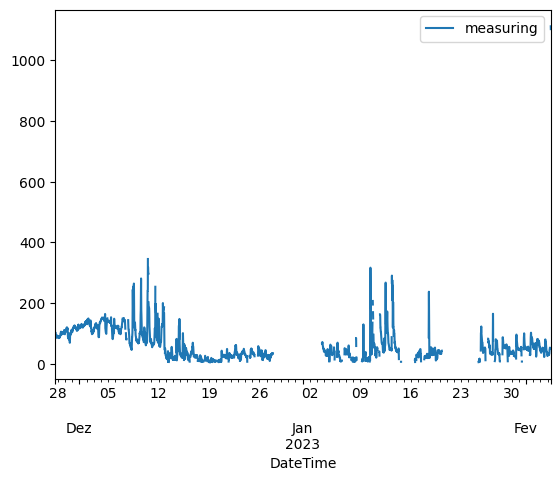

In [118]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

#### Analyse data after removing quantiles

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


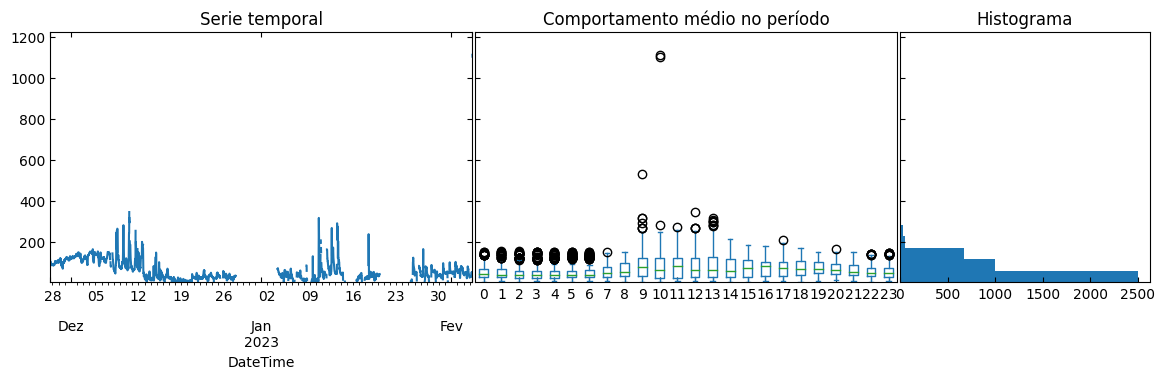

In [119]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Analyse data derivatives

Analyse the derivatives of the data for removing abrupt changes in the data (BADSPIKE)

#### Tag values with derivatives faster than sensor response time
The value of 2000 ppb was selected based on the maximum derivative found in the reference data. The maximum derivative (with measuring period of 1 hour) found was 4200 ppb. Therefore, a maximum of 4000 ppb was considered appropriate for a 15 mins period.

<Axes: xlabel='DateTime'>

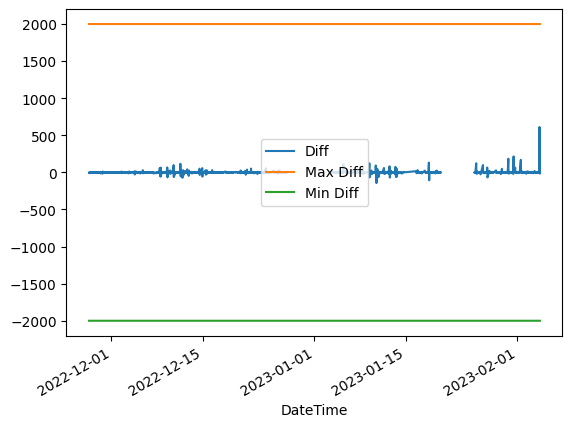

In [120]:
max_diff_value = 2000
sensor_dataframe['Diff'] = sensor_dataframe['measuring'].resample('15T').mean().diff()
sensor_dataframe['Max Diff'] = max_diff_value
sensor_dataframe['Min Diff'] = -max_diff_value
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'Max Diff', 'Min Diff']].plot()

In [121]:
import numpy as np

def tag_data_with_derivatives(tagged_df, max_diff_value):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'Max Diff']]
                           .apply(lambda df: tag_data_with_derivatives(tagged_df=df, max_diff_value=df[2]),
                                   axis=1))

<Axes: xlabel='DateTime'>

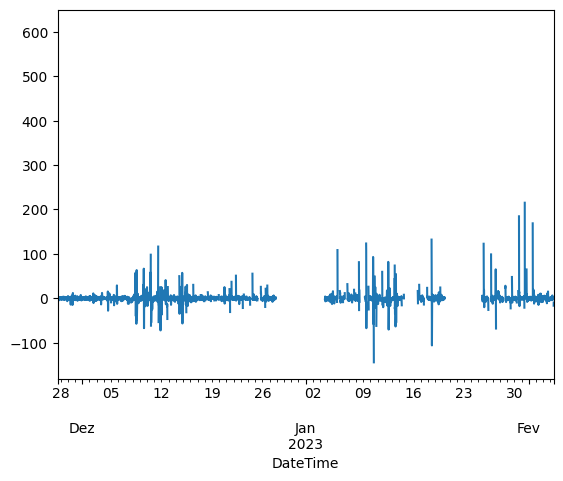

In [122]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'].resample('15T').mean().plot()

#### Plot data derivatives vs data

In [123]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']

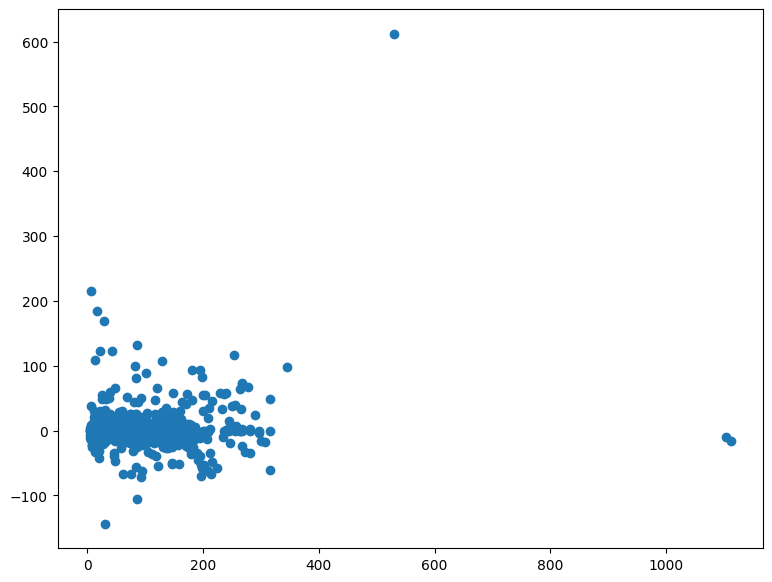

In [124]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['measuring'], valid_dataframe['Diff'])

#### Remove sample with derivative 600 and value 1000

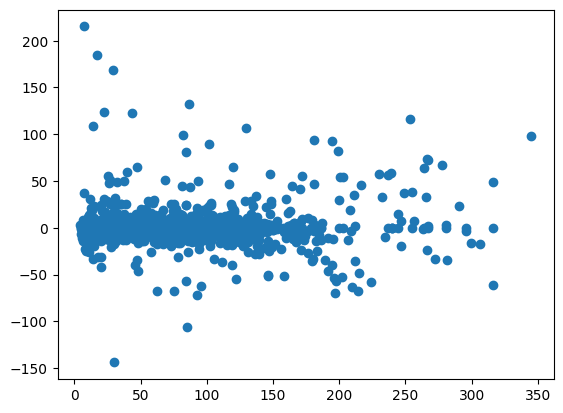

In [125]:
sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Diff', 'Tag']]
                           .apply(lambda df: 'BADSPIKE' if df[2] == 'VALID' and (df[1] >= 600 or df[0] >= 1000) else df[2], axis=1))

# sensor_dataframe.loc[sensor_dataframe['Diff'] >= 600, 'Tag'] = 'BADSPIKE'
# sensor_dataframe.loc[sensor_dataframe['measuring'] >= 1000, 'Tag'] = 'BADSPIKE'
plt.scatter(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'],
            sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'])
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']

#### Data Tag contabilization

In [127]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'REBASE']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
STABILIZING,673,3.813679
BADSPIKE,3,0.017
VALID,4270,24.196747
LTQTLE01,63,0.357001
GTQTLE99,63,0.357001
REBASE,5259,29.801099
TOTAL,17647,100.0


#### Plot valid data

Text(0, 0.5, 'Concentração (ppb)')

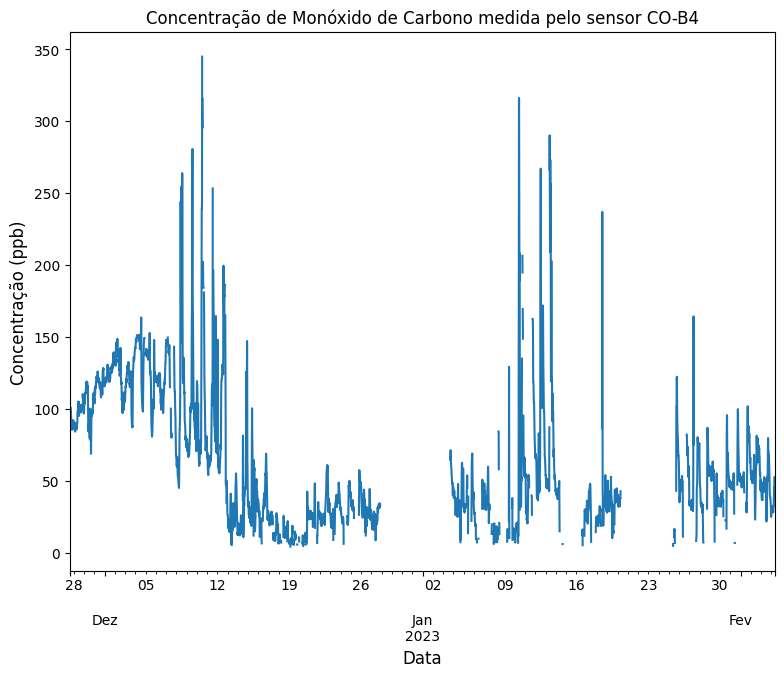

In [128]:
fig, ax = plt.subplots(figsize=(1.3*7,7))
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Monóxido de Carbono').resample('15T').mean().plot()
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


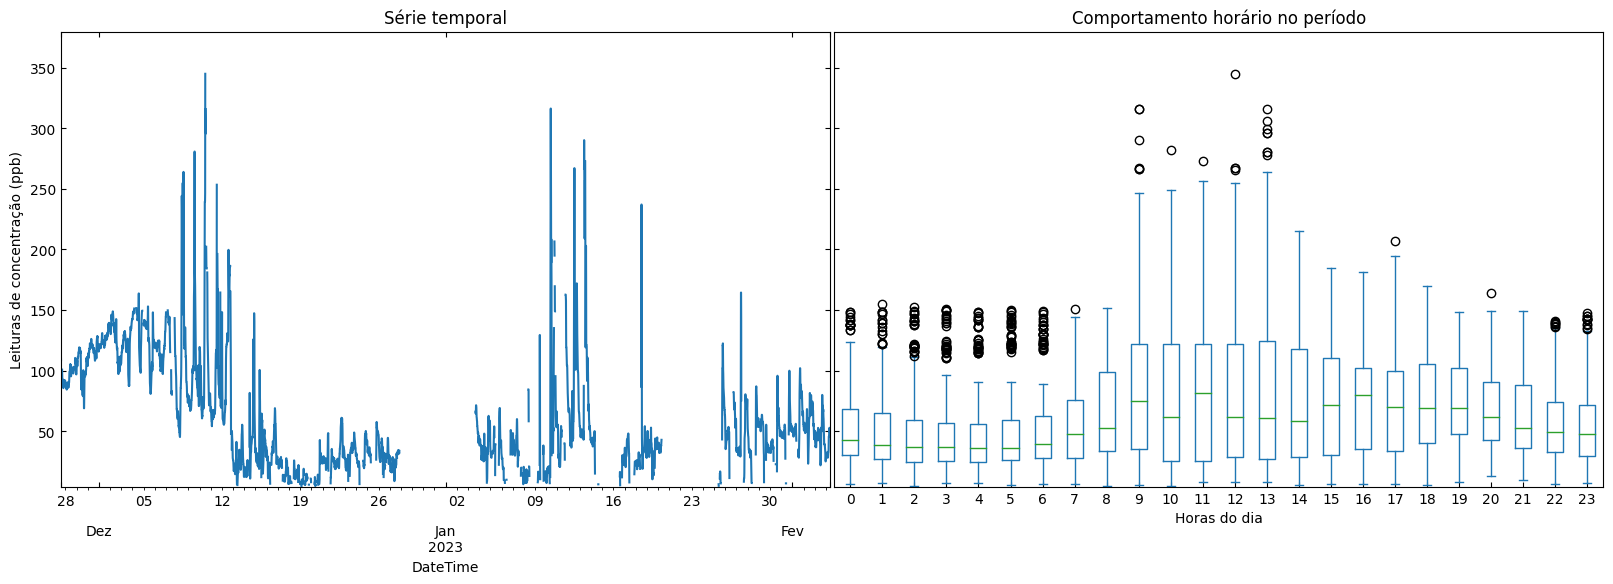

In [130]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box(df=valid_dataframe)

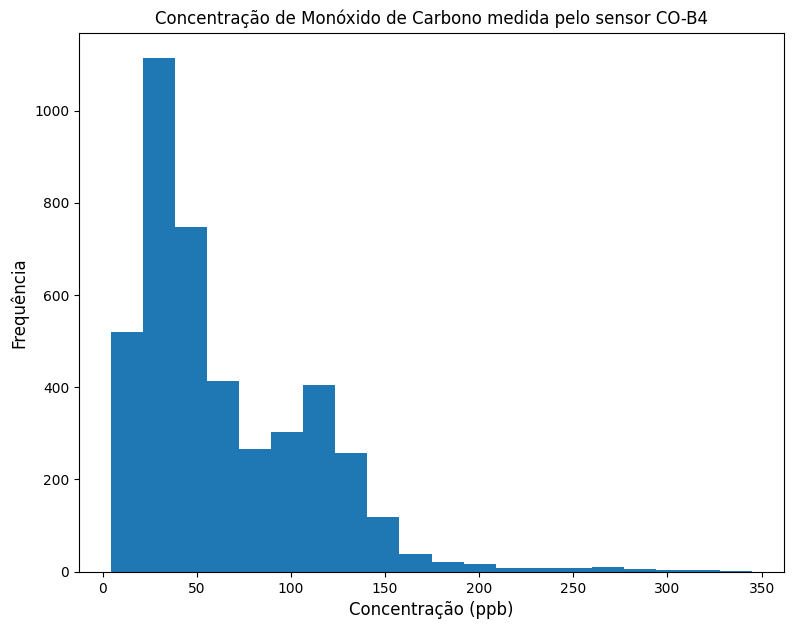

In [131]:
fig, ax = plt.subplots(figsize=(1.3*7,7))
(sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Monóxido de Carbono')
 .resample('15T').mean().hist(bins=20))
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4')
ax.set_xlabel('Concentração (ppb)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(False)

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


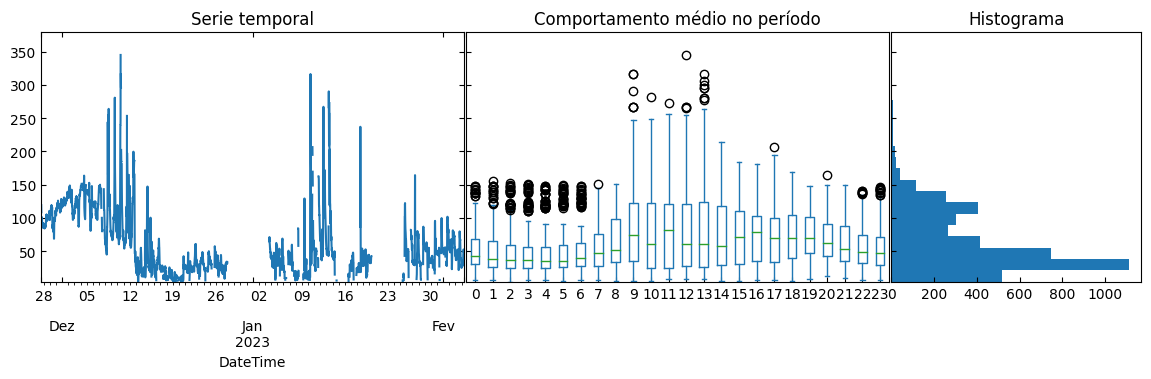

In [132]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

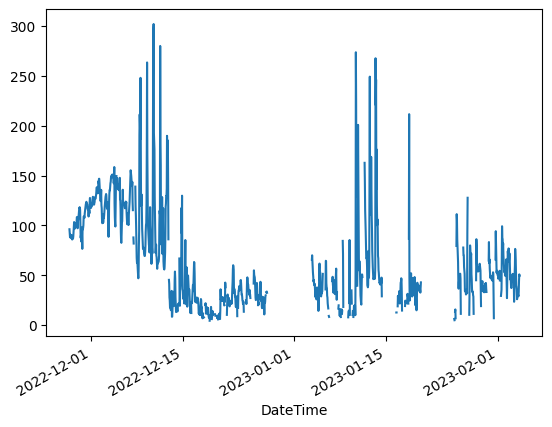

In [133]:
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

Text(0, 0.5, 'Concentração (ppb)')

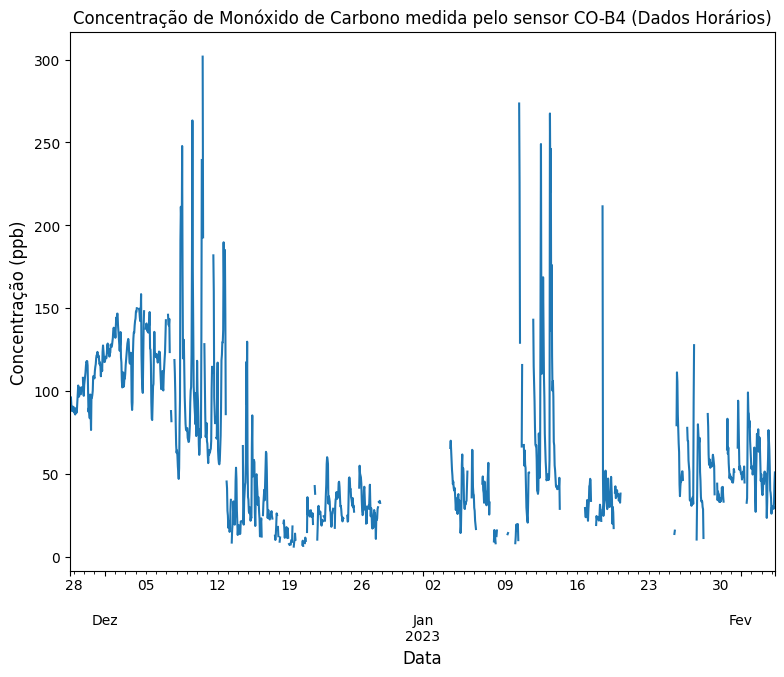

In [134]:
original_freq = sensor_dataframe.index.freq
resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                    .map(lambda c:
                                        c / (pd.Timedelta("1 hour") / original_freq) * 100))
resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))

fig, ax = plt.subplots(figsize=(1.3*7,7))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].rename('Concentração de Monóxido de Carbono').resample('1H').mean().plot()
plt.title('Concentração de Monóxido de Carbono medida pelo sensor CO-B4 (Dados Horários)')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Concentração (ppb)', fontsize=12)

#### Valid data contabilization

In [135]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,603,36.523319
VALID,1048,63.476681
TOTAL,1651,100.0


## Analyse the mean and standard deviation of the resampled data

The color of each data point represents the percentage of valid 15 mins samples found in an hour

#### Plot mean (Y axis) vs. standard deviation (X axis) for valid hourly data colored by valid percentage of valid samples

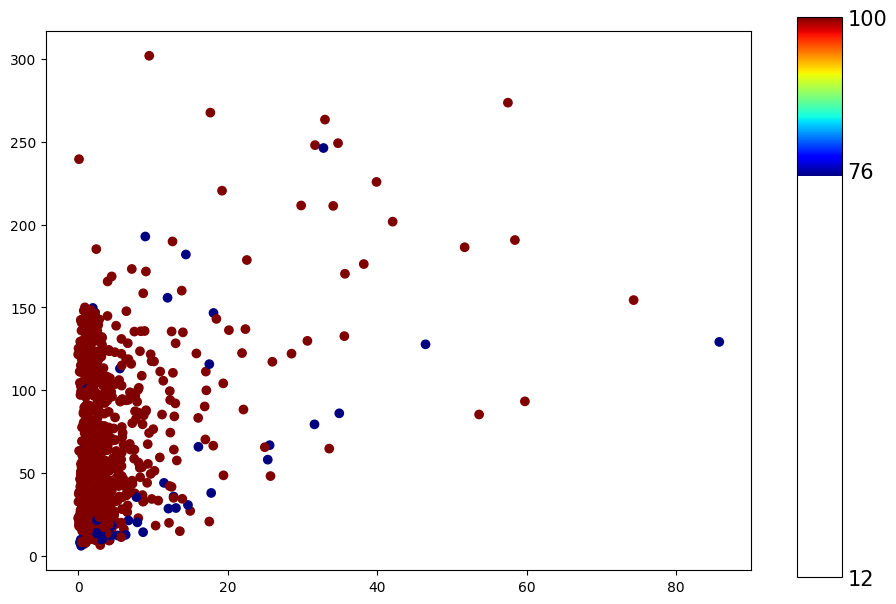

In [136]:
valid_resampled_dataframe = resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']
sensor_analysis.plot_mean_vs_std(valid_resampled_dataframe)

### Plot standard deviation in time colored according to the percentage of valid samples

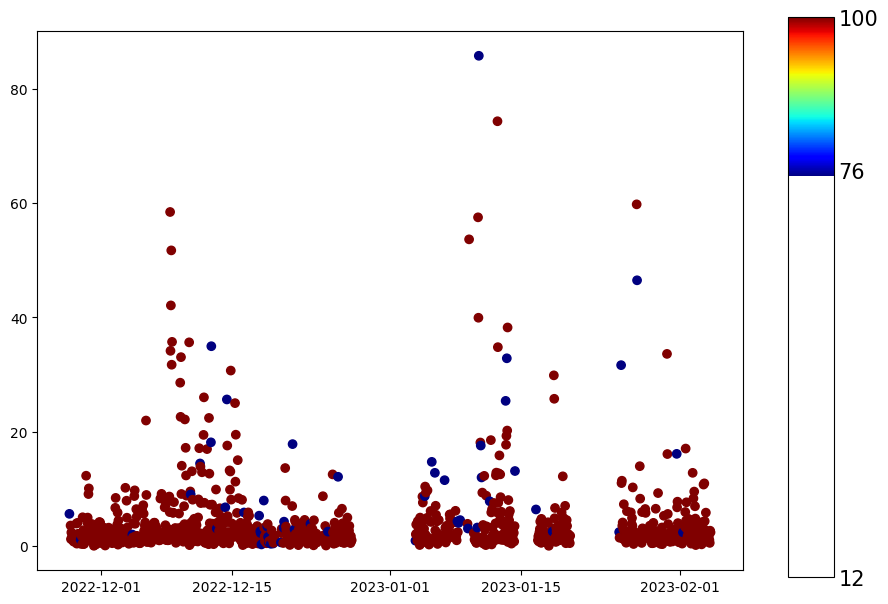

In [137]:
sensor_analysis.plot_std_in_time(valid_resampled_dataframe)

# Save Data

In [138]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_1HR_filename = '_valid_data_1HR.csv'
valid_filename = '_valid_data.csv'
dataframe_filename = '_dataframe.csv'
dataframe_1HR_filename = '_dataframe_1hr.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_1HR_filename
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

dataframe_path_1HR_output = output_directory_path + SENSOR_NAME + dataframe_1HR_filename
dataframe_path_output = output_directory_path + SENSOR_NAME + dataframe_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_1HR_filename
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

processing_dataframe_path_1HR = processing_directory_path + SENSOR_NAME + dataframe_1HR_filename
processing_dataframe_path = processing_directory_path + SENSOR_NAME + dataframe_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_file_path_output)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_1HR_file_path_output)
sensor_dataframe.to_csv(dataframe_path_output)
resampled_dataframe.to_csv(dataframe_path_1HR_output)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_file_path)
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_1HR_file_path)
sensor_dataframe.to_csv(processing_dataframe_path)
resampled_dataframe.to_csv(processing_dataframe_path_1HR)